In [22]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [24]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

print(index_to_word[1])  

<BOS>


In [25]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


def get_encoded_sentences(sentences, word_to_index):
    return [get_encodedd_sentence(sentence, word_to_index) for sentence in sentences]

 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]



In [26]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [27]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(x_train.shape)


(146182, 41)


# (1) RNN

In [28]:
vocab_size = 10000   
word_vector_dim = 16  
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [29]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 5s 12ms/step - loss: 0.5997 - accuracy: 0.6765 - val_loss: 0.3630 - val_accuracy: 0.8463
Epoch 2/8
266/266 [==============================] - 3s 10ms/step - loss: 0.3433 - accuracy: 0.8575 - val_loss: 0.3429 - val_accuracy: 0.8529
Epoch 3/8
266/266 [==============================] - 3s 10ms/step - loss: 0.3125 - accuracy: 0.8723 - val_loss: 0.3407 - val_accuracy: 0.8538
Epoch 4/8
266/266 [==============================] - 3s 10ms/step - loss: 0.2992 - accuracy: 0.8770 - val_loss: 0.3340 - val_accuracy: 0.8536
Epoch 5/8
266/266 [==============================] - 3s 10ms/step - loss: 0.2879 - accuracy: 0.8826 - val_loss: 0.3367 - val_accuracy: 0.8550
Epoch 6/8
266/266 [==============================] - 3s 10ms/step - loss: 0.2784 - accuracy: 0.8858 - val_loss: 0.3393 - val_accuracy: 0.8547
Epoch 7/8
266/266 [==============================] - 3s 10ms/step - loss: 0.2703 - accuracy: 0.8886 - val_loss: 0.3415 - val_accuracy: 0.8563
Epoch 

In [31]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3612 - accuracy: 0.8481
[0.3611895740032196, 0.84811931848526]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


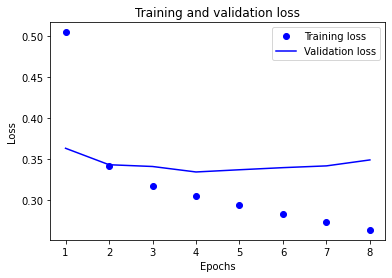

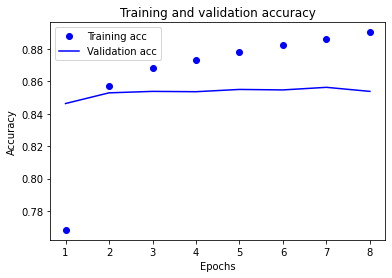

In [32]:
history_dict = history.history
print(history_dict.keys()) 


# LOSS
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACURRACY

plt.show()

plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# (2) 1 - D CNN

In [50]:
vocab_size = 10000  
word_vector_dim = 16   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 14ms/step - loss: 0.5790 - accuracy: 0.6756 - val_loss: 0.3511 - val_accuracy: 0.8447
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3234 - accuracy: 0.8640 - val_loss: 0.3357 - val_accuracy: 0.8547
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2888 - accuracy: 0.8815 - val_loss: 0.3372 - val_accuracy: 0.8531
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2569 - accuracy: 0.8968 - val_loss: 0.3413 - val_accuracy: 0.8556
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2200 - accuracy: 0.9158 - val_loss: 0.3573 - val_accuracy: 0.8518
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.1847 - accuracy: 0.9326 - val_loss: 0.3839 - val_accuracy: 0.8483
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.1549 - accuracy: 0.9463 - val_loss: 0.4273 - val_accuracy: 0.8436
Epoch

In [52]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9632 - accuracy: 0.8130
[0.9632208347320557, 0.8130072951316833]


# (3) GlobalMaxPooling1D

In [53]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
266/266 [==============================] - 2s 5ms/step - loss: 0.6421 - accuracy: 0.6583 - val_loss: 0.4044 - val_accuracy: 0.8290
Epoch 2/15
266/266 [==============================] - 1s 4ms/step - loss: 0.3766 - accuracy: 0.8422 - val_loss: 0.3531 - val_accuracy: 0.8421
Epoch 3/15
266/266 [==============================] - 1s 4ms/step - loss: 0.3219 - accuracy: 0.8645 - val_loss: 0.3452 - val_accuracy: 0.8460
Epoch 4/15
266/266 [==============================] - 1s 4ms/step - loss: 0.2948 - accuracy: 0.8777 - val_loss: 0.3448 - val_accuracy: 0.8484
Epoch 5/15
266/266 [==============================] - 1s 4ms/step - loss: 0.2743 - accuracy: 0.8888 - val_loss: 0.3486 - val_accuracy: 0.8506
Epoch 6/15
266/266 [==============================] - 1s 4ms/step - loss: 0.2582 - accuracy: 0.8952 - val_loss: 0.3549 - val_accuracy: 0.8496
Epoch 7/15
266/266 [==============================] - 1s 4ms/step - loss: 0.2420 - accuracy: 0.9025 - val_loss: 0.3630 - val_accuracy: 0.8475
Epoch 

In [56]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4660 - accuracy: 0.8329
[0.4660329520702362, 0.8328620791435242]
